In [ ]:
!pip3 install transformers
!pip3 install evaluate
!pip3 install torch
!pip3 install protobuf==3.20.3
!pip3 install snscrape
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline
from datasets import Dataset
import evaluate
from tqdm.notebook import tqdm

In [ ]:
!wget https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

--2024-06-26 22:53:31--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  6.19MB/s    in 14s     

2024-06-26 22:53:45 (5.61 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
class DataLoader():

    def import_tweets(self, path, cols=[0, 5]):
        self.tweets_df = pd.read_csv(path, usecols=cols, names=["label", "text"], encoding='latin-1') # spentiment140 specific
        self.num_tweets = self.tweets_df.shape[0]

        self.tweets_df["text"] = self.tweets_df["text"].astype(str)
        self.tweets_df["label"] = self.tweets_df["label"].astype(str)

        return self.tweets_df

    def split_tweets(self, train_size, test_size):
        self.tweets_train, self.tweets_test = train_test_split(self.tweets_df, train_size=train_size, test_size=test_size)
        return self.tweets_train, self.tweets_test

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TextClassificationPipeline
import evaluate

class TwitterSentimentClassifier():

    def __init__(self, model_name='Twitter/twhin-bert-base', num_labels=2, label2int={"0":0, "4":1}, train_size=100000, test_size=10000):
        self.model_name = model_name
        self.num_labels = num_labels
        self.train_size = train_size
        self.test_size = test_size
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.label_to_int = label2int
        self.metric_accuracy = evaluate.load("accuracy")
        self.metric_precision = evaluate.load("precision")
        self.metric_recall = evaluate.load("recall")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def tokenize_function(self, batch):
        tokenized_batch = self.tokenizer(batch["text"], padding='max_length', truncation=True, max_length=140)
        tokenized_batch["label"] = [self.label_to_int.get(label, None) for label in batch["label"]]
        return {k: v for k, v in tokenized_batch.items() if k != "label" or v is not None}

    def import_tweets(self, path):
        dl = DataLoader()
        dl.import_tweets(path)
        self.train, self.test = dl.split_tweets(self.train_size, self.test_size)

        self.train = Dataset.from_pandas(self.train)
        self.test = Dataset.from_pandas(self.test)

        self.train_dataset = self.train.map(self.tokenize_function, batched=True)
        self.test_dataset = self.test.map(self.tokenize_function, batched=True)

    def get_metrics(self, predictions, labels):
        accuracy = self.metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
        precision = self.metric_precision.compute(predictions=predictions, references=labels)["precision"]
        recall = self.metric_recall.compute(predictions=predictions, references=labels)["recall"]
        f1_score = 2 * (precision * recall) / (precision + recall)

        return {"accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1_score}

    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return self.get_metrics(predictions, labels)

    def train_model(self):
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels)
        self.model.to(self.device)
        self.training_args = TrainingArguments(
            report_to="none",
            output_dir="training_arguments",
            save_strategy="no",
            evaluation_strategy="epoch",
            per_device_train_batch_size=32,
            per_device_eval_batch_size=32,
            learning_rate=3e-5,
            weight_decay=0.01,
            num_train_epochs=3,
        )

        self.trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.test_dataset,
            compute_metrics=self.compute_metrics,
        )

        self.trainer.train()

    def save_model_local(self, path):
        self.trainer.save_model(path)

    def save_model_cloud(self):
        raise NotImplementedError("not currently implemented")

    def load_saved_model(self, path):
        self.model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=self.num_labels)
        self.model.to(self.device)
        self.pipe = TextClassificationPipeline(model=self.model, tokenizer=self.tokenizer, device=0 if self.device.type == "cuda" else -1)

    def get_scores(self, text):
        return self.pipe(text)

    def predict_dataset(self, dataset_path, batch_size=32):
        # Load the dataset
        df = pd.read_csv(dataset_path)

        # Ensure there's a 'text' column
        if 'text' not in df.columns:
            raise ValueError("The dataset must contain a 'text' column")

        # Make predictions in batches
        predictions = []
        for i in tqdm(range(0, len(df), batch_size), desc="Predicting"):
            batch = df['text'][i:i+batch_size].tolist()
            batch_predictions = self.predict(batch)
            predictions.extend(batch_predictions)

        # Add predictions to the dataframe
        df['predicted_sentiment'] = predictions

        # Map numeric predictions back to labels
        label_map = {0: "Negative", 1: "Positive"}
        df['predicted_sentiment_label'] = df['predicted_sentiment'].map(label_map)

        return df

    def predict(self, text):
        if isinstance(text, str):
            text = [text]

        inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=140, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)

        return predictions.cpu().numpy().tolist()

    def evaluate_model(self, path, cols=[0, 5]):
        dl = DataLoader()
        dl.import_tweets(path, cols=cols)

        # Filter out rows with labels not in label_to_int
        dl.tweets_df = dl.tweets_df[dl.tweets_df['label'].isin(self.label_to_int.keys())]

        self.eval = Dataset.from_pandas(dl.tweets_df)
        self.eval_dataset = self.eval.map(self.tokenize_function, batched=True)

        predictions = np.array(self.predict(self.eval_dataset["text"]))
        labels = np.array(self.eval_dataset["label"])

        return self.get_metrics(predictions, labels)

In [ ]:
ts = TwitterSentimentClassifier()

In [ ]:
dataFile = 'training.1600000.processed.noemoticon.csv'

# usecols=[label, text]
ts.import_tweets(dataFile)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
ts.train_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.353800,0.342142,0.851600,0.841728,0.866919,0.854138
2,0.266100,0.362133,0.854300,0.841893,0.873304,0.857311
3,0.174500,0.448154,0.851800,0.858448,0.843376,0.850845


In [ ]:
ts.save_model_local("twitter-sentiment-20k")

In [ ]:
ts.load_saved_model("twitter-sentiment-20k")

In [ ]:
# on manual test set from sentiment140 (2009)
ts.evaluate_model("/content/testdata.manual.2009.06.14.csv")

Parameter 'function'=<bound method TwitterSentimentClassifier.tokenize_function of <__main__.TwitterSentimentClassifier object at 0x7eaf0c99ec20>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/359 [00:00<?, ? examples/s]

{'accuracy': 0.83008356545961,
 'precision': 0.8040201005025126,
 'recall': 0.8791208791208791,
 'f1': 0.8398950131233597}

In [ ]:
results_df = ts.predict_dataset("d.csv")



# If you want to save the results
results_df.to_csv("predictions_output.csv", index=False)

Predicting: 100%|██████████| 123/123 [00:34<00:00,  3.52it/s]


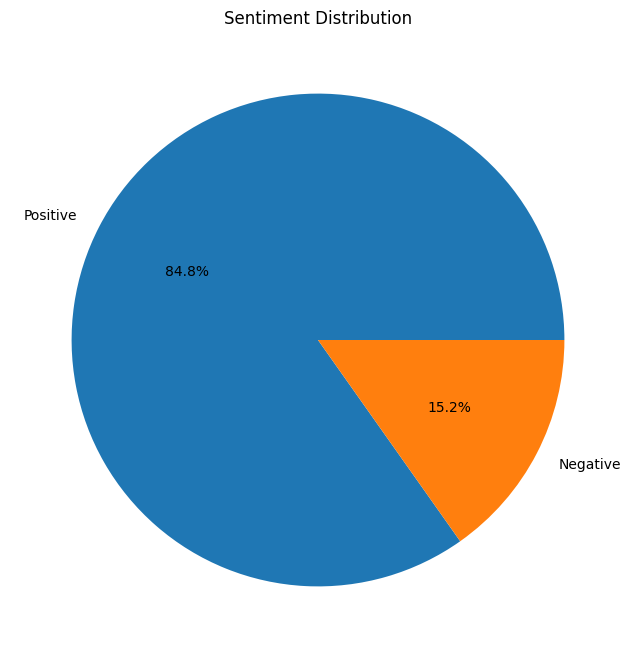

In [ ]:
import matplotlib.pyplot as plt
# Pie chart of sentiment distribution
sentiment_counts = results_df['predicted_sentiment_label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
!zip -r twitter-sentiment-0k.zip  twitter-sentiment-20k

  adding: twitter-sentiment-20k/ (stored 0%)
  adding: twitter-sentiment-20k/config.json (deflated 48%)
  adding: twitter-sentiment-20k/.ipynb_checkpoints/ (stored 0%)
  adding: twitter-sentiment-20k/training_args.bin (deflated 52%)
